In [2]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import pandas as pd 
import seaborn as sns
from glob import glob 
import numpy as np 
import optax as ox

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

## Data Read

### Obs

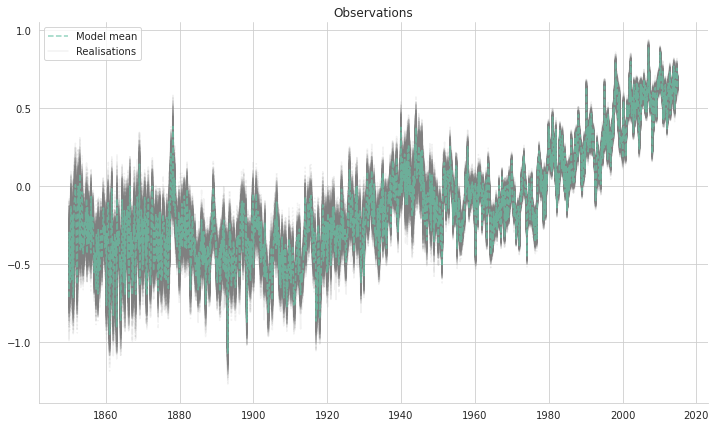

In [3]:
obs_df = pd.read_csv("data/obs/GMST_OBS.csv", index_col="time")#.iloc[:, :10]
observations = es.ProcessModel(obs_df, model_name='Observations')
observations.plot()
sns.despine()

### Anomaly model data

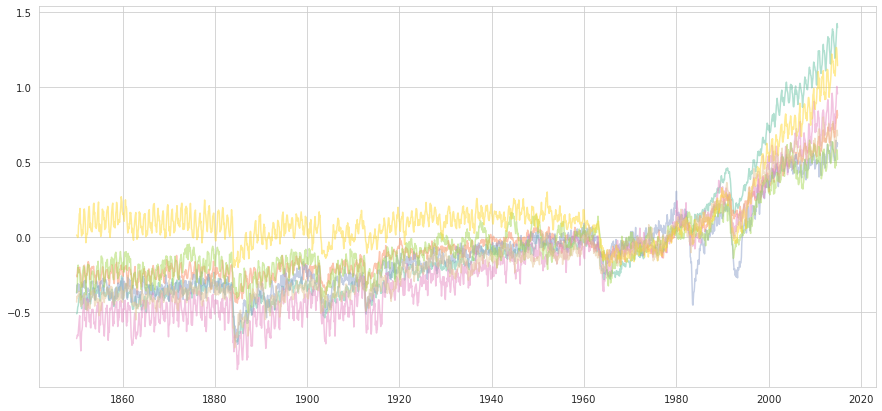

In [4]:
hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    hist_model_files[model_name] = model_file

ssp_model_files = dict()
for model_file in sorted(glob('data/gmst/ssp370/*csv')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    ssp_model_files[model_name] = model_file

model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}

hist_anom_models = []
climatology_dict = dict()

for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    df = pd.read_csv(mf, index_col='time').drop('Unnamed: 0', axis=1)
    model_data = es.ProcessModel(df, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly()
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

hist_anom_models = es.ModelCollection(hist_anom_models)
hist_anom_models.plot_all()

In [9]:
hist_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True)

Objective: -11512.50: 100%|██████████| 500/500 [00:02<00:00, 235.47it/s]


In [10]:
weight_function = es.LogLikelihoodWeight()
weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:08<00:00, 24.10it/s]


In [17]:
ensemble = es.Barycentre()
pdfs = ensemble(hist_anom_models, weights)

100%|██████████| 1980/1980 [00:18<00:00, 106.12it/s]


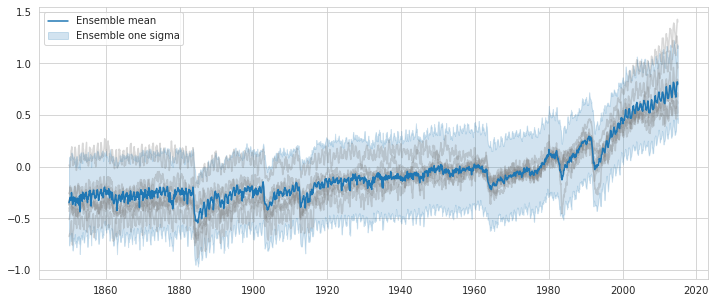

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(one_color='tab:gray', ax=ax)
ensemble.plot(ax, x=hist_anom_models.time)
ax.legend(loc='best')

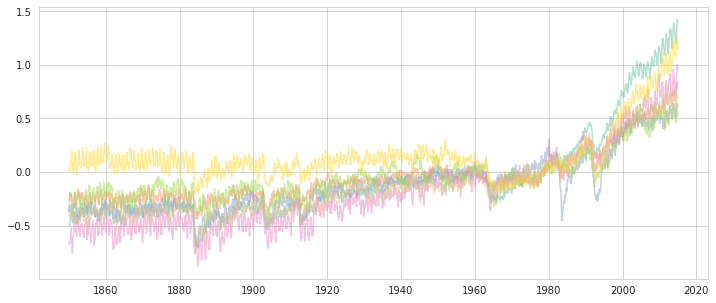

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(ax=ax)